# Calculating Cooling/Heating Degree Days using daily maximum & minimum temperature data from Cal-Adapt API

This notebook walks you through how we calculate Cooling and Heating Degree days for a county.

The daily maximum and minimum temperature datasets we will use in this exercise are raster datasets with a grid cell size of 1/16º (approximately 6 km). You can download data for an individual grid cell that corresponds to your area of interest or download data aggregated by a county boundary, watershed, etc. For a list of boundary layers supported by Cal-Adapt please see the API documentation. For this exercise we will get data for a county boundary.

In [1]:
# A 'magic' command to display plots inline
%matplotlib inline

# Import all python modules. You need to run this cell for the other cells to work.
import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'
headers = {'ContentType': 'json'}

----
## Step 1. Select location
----

The `g` (geometry parameter) is used to download data for a point, line or polygon. Geometry can be written in various formats including WKT, GeoJSON, KML. The examples below use WKT (Well Known Text) format.

#### To get data for a grid cell ...

In [2]:
point = 'POINT(-121.4687 38.5938)'
data_download_query_params = {'g': point}

#### To get data for a user defined polygon ...

The `stat` parameter is used to spatially aggregate grid cell values. Accepted values are `mean`, `max`, `min`, `count`, `median`, `std`, `var`. If you don't provide the `stat` parameter the API will return an array of grid cell values.

You can create a new polygon using this [online WKT editor](https://arthur-e.github.io/Wicket/sandbox-gmaps3.html) or any GIS software.

In [3]:
polygon = 'POLYGON ((-123.35449 39.09596, -122.27783 39.09596, -122.27783 39.97712, -123.35449 39.97712, -123.35449 39.09596))' 
data_download_query_params = {'g': polygon, 'stat': 'mean'}

#### To get data for a polygon using one of the boundary layers in Cal-Adapt API

Instead of passing raw geometry like we did earlier using the `g` parameter, you can use a polygon from boundary layers stored in the Cal-Adapt API. You need to know the `id` for this polygon and the boundary layer name. The cells below has code for doing this.

In [4]:
def get_polygon(intersecting_point, boundary):
    # Request url
    url = api + '/' + boundary + '/'
    # Request params
    params = {'intersects': intersecting_point, 'srs': 4326, 'simplify': .0001, 'precision': 4}
    # Make API request
    response = requests.get(url, params=params, headers=headers)
    if response.ok:
        data = response.json()
        feature = data['features'][0]
        if (feature):
            return feature
        else:
            return None

In [5]:
# Your point of interest
point = 'POINT(-121.4687 38.5938)'

# Name of boundary layer in API (Counties)
resource = 'counties'

# Polygon feature from resource that intersects your point
county = get_polygon(point, resource)

ref = '/api/%s/%s/' % (resource, county['id'])
data_download_query_params = {'ref': ref, 'stat': 'mean'}
data_download_query_params

{'ref': '/api/counties/34/', 'stat': 'mean'}

----
## Step 2. Download data
----

**Note: Requests might time out if the polygon is too large. If you need to process data for several boundaries we recommend downloading the daily rasters and processing the data locally.** 

Daily data is stored as a multiband raster, e.g. observed daily timeseries (1950 -2013) has 23376 bands with each band corresponding to one day, starting from 1950-01-01. Units for the observed data are degrees Celsius and projected data are in Kelvin.

The code in the next cell contains a bunch of functions to:
    - fetch daily data given a slug and query parameters
    - convert units to degrees F
    - return a new Pandas dataframe with the daily data

In [6]:
def celsius_to_F(val):
    return val * 9/5 + 32

def kelvin_to_F(val):
    return  (val - 273.15) * 9/5 + 32

def process_daily_data(slug, params):
    # Make request
    url = api + '/series/' + slug + '/rasters/'
    response = requests.get(url, params=params)
    
    # Get data
    if response.ok:
        print('Processing:', slug)
        json = response.json()
        data = json['results'][0]

        # Multiband raster data is returned by the API as a 3D array having a shape like (233376, 1, 1)
        # Flatten the 3D array into a 1D array
        values_arr = np.array(data['image'])
        values_arr = values_arr.flatten()

        # Get total number of values -> number of days
        length = len(values_arr)

        # Get start date of timeseries
        start_date = datetime.strptime(data['event'], '%Y-%m-%d')

        # Create new pandas dataframe and map each value in list to a date index
        df = pd.DataFrame(
            values_arr,
            index=pd.date_range(start_date, freq='1D', periods=length),
            columns=['value'],
        )

        # Convert units to Fahrenheit
        units = data['units']
        if units == 'C':
            df.value = df.value.apply(lambda x: celsius_to_F(x))
        elif units == 'K':
            df.value = df.value.apply(lambda x: kelvin_to_F(x))
        else:
            pass
            
        # Add climatevar as a column
        df['climvar'] = slug.split('_')[0]
    else:
        print('Failed to download:', slug)
            
    # Combine all the dataframes into one and return
    return df

### Get observed historical data for maximum and minimum daily temperatures

In [7]:
def get_observed():
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    climvar = ['tasmax', 'tasmin']
    period = ['day']
    zipped = itertools.product(climvar, period, ['livneh'])

    # Loop through zipped
    for item in zipped:
        slug = ('_').join(item)
        df = process_daily_data(slug, data_download_query_params)
        df_list.append(df)
            
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

In [8]:
observedDF = get_observed()
observedDF

Processing: tasmax_day_livneh
Processing: tasmin_day_livneh


,value,climvar
1950-01-01,47.537341,tasmax
1950-01-02,43.417568,tasmax
1950-01-03,46.940557,tasmax
1950-01-04,43.705381,tasmax
1950-01-05,45.215155,tasmax
1950-01-06,48.405793,tasmax
1950-01-07,50.585093,tasmax
1950-01-08,50.540371,tasmax
1950-01-09,50.566721,tasmax
1950-01-10,49.278330,tasmax


### Download projected maximum and minimum daily temperatures for a model

In [9]:
def get_model(name):
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    climvar = ['tasmax', 'tasmin']
    period = ['day']
    models = [name]
    scenarios = ['rcp45', 'historical']
    zipped = itertools.product(climvar, period, models, scenarios)

    # Loop through zipped
    for item in zipped:
        slug = ('_').join(item)
        df = process_daily_data(slug, data_download_query_params)
        df_list.append(df)
            
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

In [10]:
projectedDF = get_model('HadGEM2-ES')
projectedDF

Processing: tasmax_day_HadGEM2-ES_rcp45
Processing: tasmax_day_HadGEM2-ES_historical
Processing: tasmin_day_HadGEM2-ES_rcp45
Processing: tasmin_day_HadGEM2-ES_historical


,value,climvar
2006-01-01,48.389025,tasmax
2006-01-02,43.415938,tasmax
2006-01-03,37.246958,tasmax
2006-01-04,42.387708,tasmax
2006-01-05,45.945194,tasmax
2006-01-06,44.388570,tasmax
2006-01-07,48.789552,tasmax
2006-01-08,46.718450,tasmax
2006-01-09,53.679605,tasmax
2006-01-10,54.822800,tasmax


## 3.  Calculate Degree Days

In [11]:
base_temp = 65

# Calculate average of tasmax & tasmin for each day
observedAvg = observedDF.groupby(observedDF.index).mean()
projectedAvg = projectedDF.groupby(projectedDF.index).mean()

### Heating Degree Days

In [12]:
def calculate_hdd(df, base):
    # Find days with average temperature below base temperature
    dfHDD = pd.DataFrame(df.loc[df['value'] < base])
    # Calculate absolute value of difference between average temperature & base temperature
    dfHDD['value'] = abs(dfHDD['value'] - base)
    # Sum total number of heating degrees by year
    dfHDD = dfHDD.value.resample('1AS').sum()
    return dfHDD

In [13]:
# Get total number of heating degree days
observedHDD = calculate_hdd(observedAvg, base_temp)
observedHDD

1950-01-01    2557.536516
1951-01-01    2757.516890
1952-01-01    2897.365732
1953-01-01    2666.221328
1954-01-01    2842.955380
1955-01-01    2926.215127
1956-01-01    2771.236711
1957-01-01    2730.596596
1958-01-01    2322.724240
1959-01-01    2238.973657
1960-01-01    2638.744205
1961-01-01    2926.790577
1962-01-01    2890.715479
1963-01-01    3068.462441
1964-01-01    2794.810765
1965-01-01    2800.790085
1966-01-01    2461.303726
1967-01-01    2947.403880
1968-01-01    2614.531387
1969-01-01    2700.340172
1970-01-01    2462.958908
1971-01-01    3172.806912
1972-01-01    2914.982592
1973-01-01    2593.613999
1974-01-01    2673.965752
1975-01-01    2924.168048
1976-01-01    2232.655086
1977-01-01    2448.175153
1978-01-01    2450.412242
1979-01-01    2532.564110
                 ...     
1984-01-01    2507.067024
1985-01-01    2885.052830
1986-01-01    2048.273324
1987-01-01    2366.033877
1988-01-01    2277.290735
1989-01-01    2599.799791
1990-01-01    2466.730672
1991-01-01  

In [14]:
# Get total number of heating degree days
projectedHDD = calculate_hdd(projectedAvg, base_temp)
projectedHDD

1950-01-01    2742.273831
1951-01-01    2501.170541
1952-01-01    2505.054585
1953-01-01    2294.225735
1954-01-01    2389.738468
1955-01-01    2649.696724
1956-01-01    2503.488913
1957-01-01    2611.369399
1958-01-01    2606.452165
1959-01-01    2917.804149
1960-01-01    2445.666877
1961-01-01    2563.254394
1962-01-01    2592.987390
1963-01-01    3012.010013
1964-01-01    2864.506308
1965-01-01    2412.403936
1966-01-01    2380.803150
1967-01-01    2919.901990
1968-01-01    2629.730394
1969-01-01    2530.029408
1970-01-01    2351.352920
1971-01-01    2611.795280
1972-01-01    2264.456472
1973-01-01    2458.241423
1974-01-01    2340.860754
1975-01-01    2523.804683
1976-01-01    2783.033555
1977-01-01    2531.997724
1978-01-01    2426.253218
1979-01-01    2821.723735
                 ...     
2070-01-01    2049.909130
2071-01-01    1649.651691
2072-01-01    1694.543678
2073-01-01    1995.049321
2074-01-01    1716.642088
2075-01-01    2054.410826
2076-01-01    1366.919658
2077-01-01  

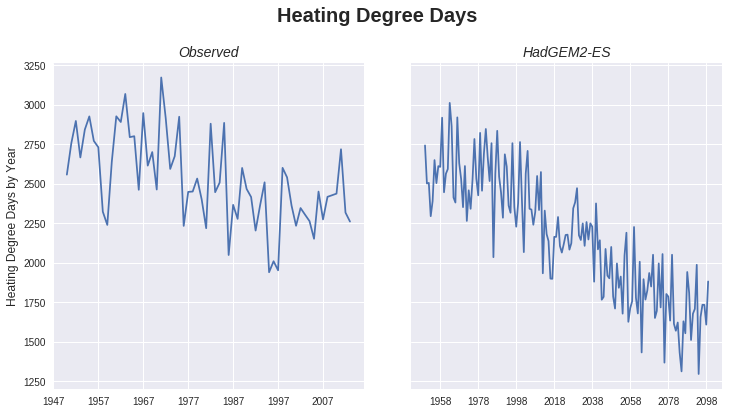

In [15]:
# Plot the data
f, (ax1, ax2) = plt.subplots(1, 2, sharey='all', figsize=(12, 6))

l1 = ax1.plot(observedHDD)
ax2.plot(projectedHDD)

ax1.set_title('Observed', fontstyle='italic', fontsize=14)
ax1.set_ylabel('Heating Degree Days by Year', fontsize=12)
ax2.set_title('HadGEM2-ES', fontstyle='italic', fontsize=14)

plt.subplots_adjust(wspace=0.15)

f.suptitle('Heating Degree Days', y=1.01, fontsize=20, fontweight='bold')

### Cooling Degree Days

In [16]:
def calculate_cdd(df, base):
    # Find days with average temperature above base temperature
    dfCDD = pd.DataFrame(df.loc[df['value'] > base])
    # Calculate absolute value of difference between average temperature & base temperature
    dfCDD['value'] = abs(dfCDD['value'] - base)
    # Sum total number of cooling degrees by year
    dfCDD = dfCDD.value.resample('1AS').sum()
    return dfCDD

In [17]:
# Get total number of heating degree days
observedCDD = calculate_cdd(observedAvg, base_temp)
observedCDD

1950-01-01    1226.595449
1951-01-01    1026.217860
1952-01-01    1151.352171
1953-01-01     985.460288
1954-01-01     934.968431
1955-01-01    1032.311150
1956-01-01    1030.875979
1957-01-01    1113.157129
1958-01-01    1336.122221
1959-01-01    1228.642621
1960-01-01    1272.584020
1961-01-01    1316.073106
1962-01-01     970.319115
1963-01-01     978.804937
1964-01-01    1030.546523
1965-01-01     927.712452
1966-01-01    1226.226768
1967-01-01    1419.893979
1968-01-01    1145.555212
1969-01-01    1253.526761
1970-01-01    1228.685782
1971-01-01    1183.260697
1972-01-01    1167.298843
1973-01-01    1237.553347
1974-01-01    1297.894775
1975-01-01    1301.078973
1976-01-01    1356.406912
1977-01-01    1188.504322
1978-01-01    1254.639933
1979-01-01    1384.654476
                 ...     
1984-01-01    1627.669607
1985-01-01    1277.191395
1986-01-01    1155.900819
1987-01-01    1330.214675
1988-01-01    1557.380026
1989-01-01    1191.794940
1990-01-01    1493.951628
1991-01-01  

In [18]:
# Get total number of heating degree days
projectedCDD = calculate_cdd(projectedAvg, base_temp)
projectedCDD

1950-01-01    1189.107535
1951-01-01    1377.492386
1952-01-01    1381.721695
1953-01-01    1393.106304
1954-01-01     966.717167
1955-01-01    1018.426507
1956-01-01    1203.997459
1957-01-01    1488.415317
1958-01-01    1254.158733
1959-01-01    1343.965670
1960-01-01    1380.141625
1961-01-01    1401.698134
1962-01-01    1082.034998
1963-01-01     971.455716
1964-01-01    1299.405471
1965-01-01    1289.429195
1966-01-01    1465.531027
1967-01-01    1210.485517
1968-01-01    1363.607785
1969-01-01    1377.540234
1970-01-01    1269.134621
1971-01-01    1176.833920
1972-01-01    1432.361182
1973-01-01    1486.948414
1974-01-01    1326.719616
1975-01-01    1153.824214
1976-01-01    1437.445081
1977-01-01    1425.584567
1978-01-01    1288.613411
1979-01-01    1106.494829
                 ...     
2070-01-01    2714.598913
2071-01-01    2511.503632
2072-01-01    2410.734785
2073-01-01    2067.844076
2074-01-01    2749.656618
2075-01-01    2587.979938
2076-01-01    2373.495863
2077-01-01  

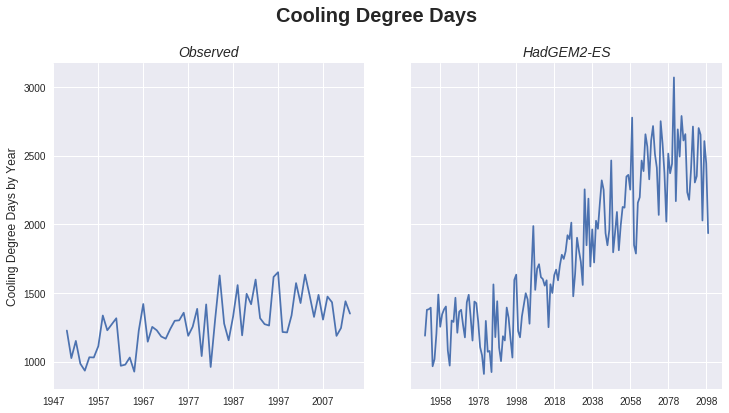

In [19]:
# Plot the data
f, (ax1, ax2) = plt.subplots(1, 2, sharey='all', figsize=(12, 6))

l1 = ax1.plot(observedCDD)
ax2.plot(projectedCDD)

ax1.set_title('Observed', fontstyle='italic', fontsize=14)
ax1.set_ylabel('Cooling Degree Days by Year', fontsize=12)
ax2.set_title('HadGEM2-ES', fontstyle='italic', fontsize=14)

plt.subplots_adjust(wspace=0.15)

f.suptitle('Cooling Degree Days', y=1.01, fontsize=20, fontweight='bold')